In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

In [8]:
with open("./config/main.yaml", "r") as f:
    config = yaml.safe_load(f)

T = config["T"]
n = config["n"]
delta = config["delta"]
embed_dim = config["embed_dim"]
signal_norm = config["signal_norm"]

log_term = np.log(T * n / delta)
print(log_term)
print("A1: {} > {}, {}".format(embed_dim, n * signal_norm ** 2, n ** 2 * log_term ** 2))
print("A2: {} > {}".format(signal_norm, embed_dim ** 0.25 * log_term ** 0.5))

9.680344001221918
A1: 4000 > 8000.0, 37483.62399279727
A2: 20.0 > 24.743457954703523


In [4]:
df = pd.read_csv("/work/gu14/k36078/benign-attention/outputs/2024-09-10/20-23-42/attention_scores.csv")
df = pd.read_csv("/work/gu14/k36078/benign-attention/outputs/2024-09-10/20-34-01/attention_scores.csv")

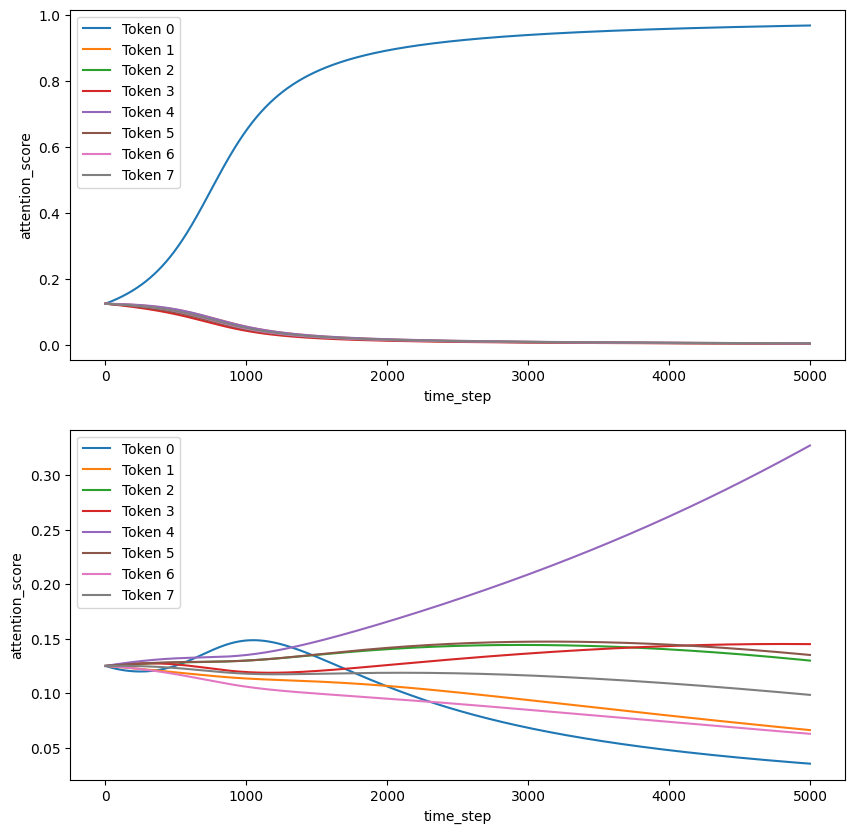

In [5]:
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"]]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for token_id in range(8):
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=f"Token {token_id}")
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1], label=f"Token {token_id}")

